In [1]:
import numpy as np
from numpy import exp
from scipy.special import jn_zeros, j0, j1
import matplotlib.pyplot as plt
import fipy as fp
from mpl_toolkits.mplot3d import Axes3D

In C:\Users\antoine\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\antoine\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\antoine\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\antoine\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\antoine\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_c

Équation de la chaleur 
\begin{equation}
\rho C \frac{\partial T}{\partial t}=\lambda \frac{\partial^2T}{\partial x^2}
\end{equation}
on suppose que le spagheetti est entierement dans l'eau bouyanthe

In [2]:
#constantes
global a
global D
global Nterm
Ti=20#°C initiale de la spaghetti
Tc=70#°C cuisson de la spaghetti
Te=100#°C eau choode
Lp=250#longueur d'une pate
a=1#rayon d'une patte
h=21#J/K/kg
c=2.9#j/kg/K
lambdaa= 0.16#W/m/K
#1m3=10**6cm3
rho=0.75*10**(3)#masse volumique kg/m3
#Blé 305 14,7 0,16 Masse volumique : 0,75 g/cm3 ; [35]
Nterm = 20
#pour fipy
dr=0.1#increment spacial
nr=10#nombre de cellules?
Lr=1#rayon du domaine
D=lambdaa/(rho*c)

In [3]:
def crank522(r, t):
    '''evaluate eqn 5.22 for a given r,t

    the following global variables need to be set
    a : radius of cylinder
    D : diffusion coefficient
    Nterm : number of terms to be evaluated
    '''
    T0=100
    T1=20
    aalp = jn_zeros(0,Nterm)
    alpha = aalp/a

    XJ0 = exp(-D * alpha**2 * t) * j0(r*alpha)
    AJ1 = alpha * j1(aalp)

    S = np.sum(XJ0/AJ1)
    T=T0-(T0-T1)*2*S/a
    return T

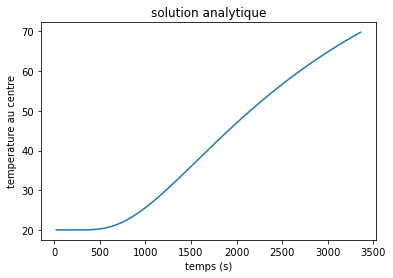

3380 70.05665429043304


In [4]:
# create radial axis
r = np.linspace(0.,1.,200)
# evaluate crank522 at different points in time, and plot
t=0
dt=20
c = np.array([crank522(rr,t) for rr in r])
temp=[]
Temp=[]
while c[Nterm]<70:
    Temp.append(c[Nterm])
    temp.append(t)
    t+=dt
    c = np.array([crank522(rr,t) for rr in r])
plt.plot(temp[1::],Temp[1::])
plt.xlabel('temps (s)')
plt.ylabel('temperature au centre')
plt.title('solution analytique')
plt.show()
print(t,c[Nterm])

## Finite-volume solution with Fipy.

Define 1D cylindrical grid with a variable called 'c', initialized to an initial value of 0.0 everywhere.

In [5]:
mesh = fp.CylindricalGrid1D(nr = 50, Lr = 1.0)

In [6]:
c = fp.CellVariable(mesh = mesh, value = 20.0)

Apply boundary condition: outer wall will be kept at 1.0. (Dirichlet boundary condition).

In [7]:
c.constrain(100.0, mesh.facesRight)

We should also define our partial differential equation! (With Fipy, this step comes last).

In [8]:
eq = fp.TransientTerm(var=c) == fp.DiffusionTerm(var=c, coeff=D)

Now, we solve the equation by taking time steps. We plot the solution at several specified time-points.

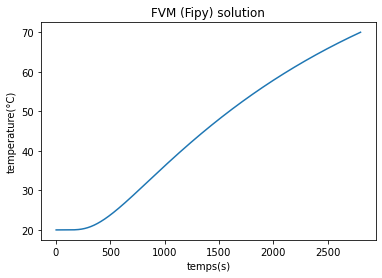

2803 70.00070234393766


In [9]:
t=[]
Temperature=[]
to=0
ddt=1
while c.value[Nterm]<70:
    c.mesh.cellCenters.value[0]
    eq.solve(dt = ddt)
    to+=ddt
    t.append(to)
    Temperature.append(c.value[Nterm])
plt.plot(t,Temperature)
plt.xlabel('temps(s)')
plt.ylabel('temperature(°C)')
plt.title('FVM (Fipy) solution')
plt.show()
print(t[-1],Temperature[-1])


## Implémentation de la concentration d'eau fonction du rayon et du temps.
On verra ce qu'on fait de ca après.\
Faudrait en déduire la mass e volumique local (un truc du type) la capacité thermique
et la conductivité pour en déduire la diffusion de la température correctement\
Pour le cylindre plein S3 (R=0.09 cm) temps de cuisson optimal (13min)

\begin{equation}

\end{equation} 

In [26]:
#Initialisation
C0=0 #g/g eau/semoule concentration
s0=0 #inutile
D0=4.3*10**(-7) #coefficient de diffusion initial (cm²/s)
Gma=14.7 #variation du coeff de diffusion
Cg=1.8 #Concentration critique? gelatinisation
Cb=1.9 #un truc relatif a celui d'au dessus
Bta=3.6*10**(-8)
Lr=.1#rayon du domaine


<IPython.core.display.Javascript object>


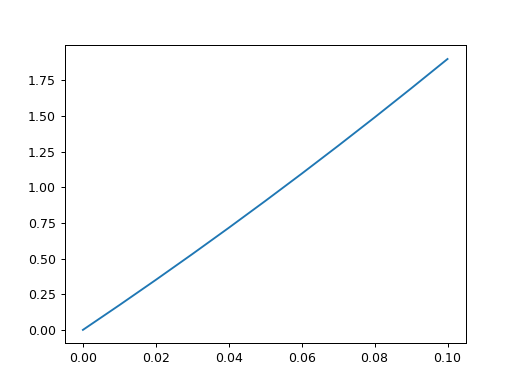

In [27]:
%matplotlib notebook
Tfin=10

Tter=10**4
Rter=10

x=np.linspace(0,Lr,Rter+1)#Rayons
dx=Lr/Rter

temps=np.linspace(0,Tfin,Tter+1)
dt=Tfin/Tter

def Dfonc(C):
    if C<Cg:
        return(D0)
    else:
        return(Gma*D0)
def Sfonc(C):
    return Dfonc(C)*dt/dx**2


C=np.zeros(Rter+1)
# C=50*np.ones(Rter+1)
# C[0]=0
# C[-1]=100
concentration=[]
Lc=0
for i in range(Tter):
    concentration.append(C.copy())
    Cd=C0+4*Sfonc(C0)*Lc
    Cf=Cb+Bta*i*dt
    C[-1]=Cf
    C[0]=Cd
    for j in range(1,Rter):
        Cij=C[j]
        if j==0:
            dC=0
        else:
            dC=(C[j+1]-C[j-1])/(2*dx)
        ddC=(C[j+1]-2*C[j]+C[j-1])/dx**2
        m1=dC*(Dfonc(C[j+1])-Dfonc(C[j-1]))/dx
        m2=Dfonc(Cij)*(Cij-dC*2+ddC)/dx**2#merse
        m3=Dfonc(Cij)*dC/(j*dx)#merde
        #print(C[j+1],Cij,C[j-1])
        C[j]+=(m1+m2+m3)*dt
        #C[j]+=dt*1e-5/dx**2*(C[j+1]+C[j-1]-2*C[j])
    Lc=(C[1]-C[0])
plt.plot(x,concentration[-1])
plt.show()
   

## End.
